#### TODO

- [ ] Generate the random dispersing centers
- [ ] Define the free space Green's function
- [ ] Create the M matrix
- [ ] solve the linear system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.special import hankel1
from scipy.constants import pi, hbar

Defining the energy as:

$$E'=\frac{\hbar^2k^2}{2m}$$

We can extract $k$ as:

$$k=\sqrt{\frac{2mE'}{\hbar^2}}$$

But, energy is given in units of $E_0=\frac{\hbar^2}{md^2}$, such that $E=E'/E_0$, so we can write:

$$k=\sqrt{\frac{2mE'}{\hbar^2}}=\sqrt{\frac{2mE_0E}{\hbar^2}}=\sqrt{\frac{2E}{d^2}}$$

/home/pfargas/anaconda3/envs/tfm/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/pfargas/anaconda3/envs/tfm/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


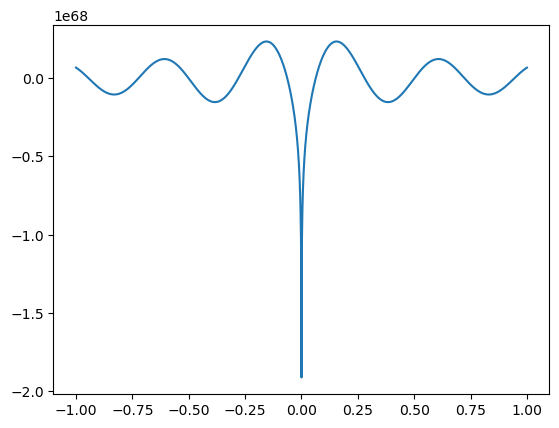

In [2]:
r=np.linspace(-1, 1, 10000)
energy=100
def free_space_green_function(energy, r, m=1, d=1):
    k=np.sqrt(2*energy/d**2) # Careful with the units, if big number, hankel returns nan
    return -(1j*m)/(2*hbar**2) * hankel1(0, k*r)

plt.plot(r, free_space_green_function(energy, r))

In [3]:
def generate_circular_lattice(n):
    x = np.linspace(-1, 1, n)
    y = np.linspace(-1, 1, n)
    X, Y = np.meshgrid(x, y)

    # mask out the points outside the circle
    R = np.sqrt(X**2 + Y**2)
    mask = R <= 1

    # generate a mesh of points in the circle
    X = X[mask]
    Y = Y[mask]
    return X, Y

In [4]:
def generate_circular_lattice(radius=2, spacing=0.01, n=None):
    if n is None:
        n = int(radius/spacing)
    
    x = np.linspace(-radius, radius, n)
    y = np.linspace(-radius, radius, n)
    X, Y = np.meshgrid(x, y)

    # mask out the points outside the circle
    R = np.sqrt(X**2 + Y**2)
    mask = R <= radius

    # generate a mesh of points in the circle
    X = X[mask]
    Y = Y[mask]
    return X, Y

Careful with the units, as the energy is given in units of $E_0$, the wavevector is given in units of $1/d$.

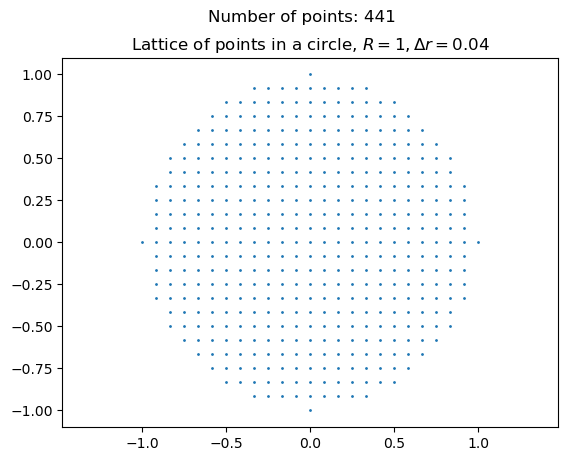

In [5]:
R=1
spacing=0.04

X,Y=generate_circular_lattice(radius=R, spacing=spacing)

plt.scatter(X, Y, s=1)
plt.title(f'Lattice of points in a circle, $R={R}, \Delta r={spacing}$')
plt.suptitle(f'Number of points: {len(X)}')

plt.axis('equal');

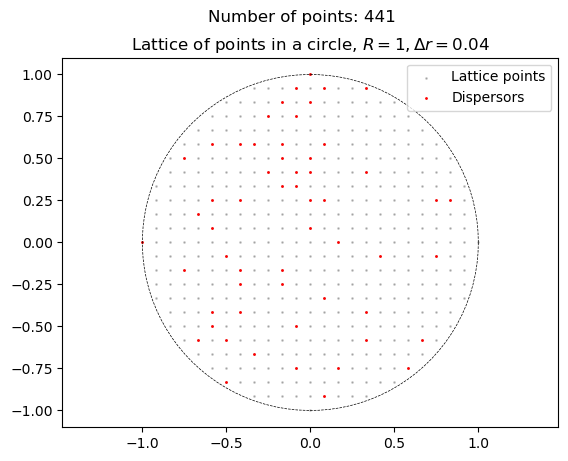

In [6]:
R=1
spacing=0.04

X,Y=generate_circular_lattice(radius=R, spacing=spacing)

# choose each point with probability p
p=.1
np.random.seed(42) # !!!for reproducibility
mask = np.random.rand(len(X)) < p
X_dispersors=X[mask]
Y_dispersors=Y[mask]

plt.scatter(X, Y, s=1, label='Lattice points', color=(0,0,0,0.2))
plt.scatter(X_dispersors, Y_dispersors, s=1, label='Dispersors', c='r')
plt.title(f'Lattice of points in a circle, $R={R}, \Delta r={spacing}$')
plt.suptitle(f'Number of points: {len(X)}')
# plot a circle of radius R
t = np.linspace(0, 2*pi, 100)
plt.plot(R*np.cos(t), R*np.sin(t), 'k--', linewidth=0.5)
plt.legend()
plt.axis('equal');


This verifies the continuum limit which is that the area of a circle is given by $A=\pi (l/2)^2$, and the area of a square is given by $A=l^2$, so:

$$\frac{A_{circle}}{A_{square}}=\frac{\pi (l/2)^2}{l^2}=\frac{\pi}{4}\sim 0.785398...\to A_{circle}=\frac{\pi}{4}A_{square}\approx_{N\to \infty} N_{circle}=\frac{\pi}{4}N_{square}$$

# Linear system of equations

The linear system of equations is given by:

$$\sum_{j=1}^{N}M_{ij}D_j=\frac{i\pi}{2}H_0^{(1)}(k(r_i-r_0))$$

Where $M_{ij}$ is given by:

$$M_{ij}=\left \{\begin{matrix}-\frac{i\pi}{2}H_0^{(1)}(k(r_i-r_j))& i\neq j\\\ln{\left(\frac{ka_{eff}e^\gamma}{2}\right)}-\frac{i\pi}{2} & i=j\end{matrix}\right.$$

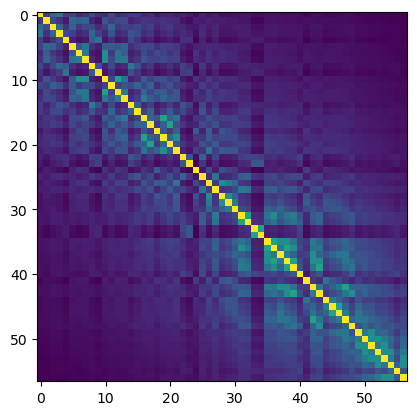

In [36]:
m_matrix = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)
energy = 1
d=1
a_eff = 0.1
k=np.sqrt(2*energy)/d

gamma_euler = 0.57721566490153286060

for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
    for j, (x_prime, y_prime) in enumerate(zip(X_dispersors, Y_dispersors)):
        if i == j:
            m_matrix[i, j] = np.log(k*a_eff*np.exp(gamma_euler))-1j*np.pi/2
        else:
            m_matrix[i, j] = -1j*np.pi/4*hankel1(0, k*np.sqrt((x-x_prime)**2+(y-y_prime)**2))
            
plt.imshow(np.abs(m_matrix), cmap='viridis')

Defining the system of equations as:

$$\mathbf{M}\mathbf{D}=\mathbf{B}$$

In [37]:
r0 = np.array([-0.10, 0.5])

B_vector = np.zeros(len(X_dispersors), dtype=np.complex128)

for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
    B_vector[i] = 1j*np.pi/2*hankel1(0, k*np.sqrt((x-r0[0])**2+(y-r0[1])**2))
    
D_vector = np.linalg.solve(m_matrix, B_vector)

Text(0.5, 0, 'Dispersor index $i$')

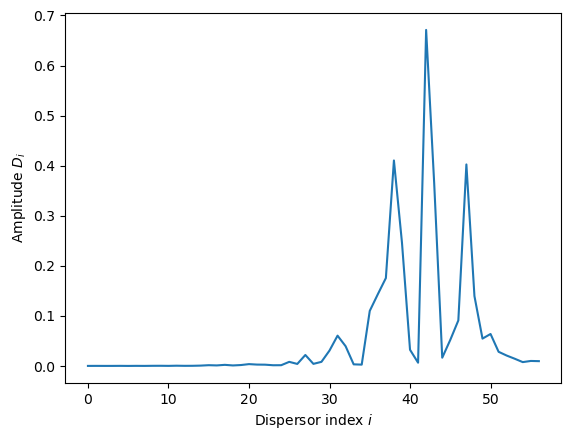

In [43]:
plt.plot(np.abs(D_vector))
plt.ylabel(r'Amplitude $D_i$')
plt.xlabel(r'Dispersor index $i$')

Text(0.5, 1.0, 'Magnitude of the scattered field')

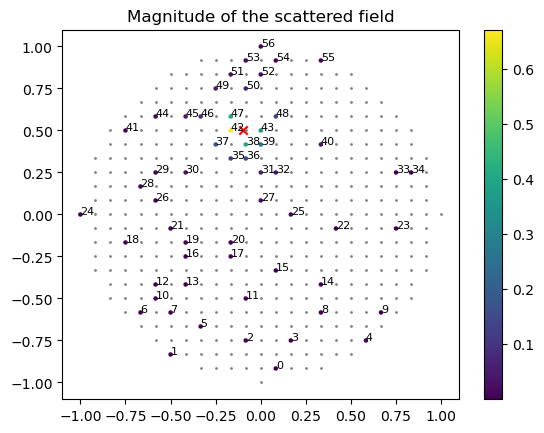

In [49]:
plt.figure()
plt.scatter(r0[0], r0[1], c='r', label='Source',marker='x')
plt.scatter(X,Y, c="grey", s=1, label='Lattice points')
plt.scatter(X_dispersors, Y_dispersors, c=np.abs(D_vector), cmap='viridis',s=5)
for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
    plt.text(x, y, f'{i}', fontsize=8)
plt.colorbar()
plt.title('Magnitude of the scattered field')
